#### **This notebook used for test how to find the best sample from 5000 chains**

In [1]:
import psycopg2
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from psycopg2.extras import RealDictCursor
from scipy.stats import pearsonr, spearmanr
from scipy import sparse
from scipy.sparse import load_npz

In [20]:
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="test",
    user="siyuanzhao",
    cursor_factory=RealDictCursor
)
chromosome_name = 'chr8'
cell_line = 'NHEK'
sequences = {"start": 127300000, "end": 128300000}

In [21]:
hic_file = "hic_data.csv"
position_file = "../Backend/example_data/NHEK_chr8_127300000_128300000_original_position.csv"
distance_file = "../Backend/example_data/NHEK_chr8_127300000_128300000_original_distance.csv"
csv.field_size_limit(sys.maxsize)

cur = conn.cursor()
# with open(hic_file, mode='r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         hid = row["hid"]
#         chrid = row["chrid"]
#         ibp = row["ibp"]
#         jbp = row["jbp"]
#         fq = row["fq"]
#         fdr = row["fdr"]
#         rawc = row["rawc"]
#         cell_line = row["cell_line"]

#         insert_query = """
#             INSERT INTO non_random_hic (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
#         """

#         cur.execute(insert_query, (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line))

# conn.commit()

with open(position_file, mode='r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        pid = row["pid"]
        cell_line = row["cell_line"]
        chrid = row["chrid"]
        sampleid = row["sampleid"]
        start_value = row["start_value"]
        end_value = row["end_value"]
        x = row["x"]
        y = row["y"]
        z = row["z"]
        insert_time = row["insert_time"]
        
        insert_query = """
            INSERT INTO position (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """

        cur.execute(insert_query, (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time))

conn.commit()

with open(distance_file, mode='r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        did = row["did"]
        cell_line = row["cell_line"]
        chrid = row["chrid"]
        sampleid = row["sampleid"]
        start_value = row["start_value"]
        end_value = row["end_value"]
        n_beads = row["n_beads"]
        distance_vector = row["distance_vector"]
        insert_time = row["insert_time"]
        
        insert_query = """
            INSERT INTO distance (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """

        cur.execute(insert_query, (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time))

conn.commit()

In [22]:
def get_position_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT *
        FROM position
        WHERE chrid = %s
        AND cell_line = %s
        AND start_value = %s
        AND end_value = %s
        ORDER BY sampleid, pid
    """,
        (chromosome_name, cell_line, sequences["start"], sequences["end"]),
    )
    data = cur.fetchall()
    cur.close()
    return data


def get_avg_distance_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
        AND chrid = %s
        AND start_value = %s
        AND end_value = %s
    """,
        (cell_line, chromosome_name, sequences["start"], sequences["end"]),
    )

    rows = cur.fetchall()
    cur.close()
    if not rows:
        return []

    vectors = []
    for row in rows:
        raw_vector = row['distance_vector']
        vec = np.frombuffer(raw_vector, dtype=np.float32)
        vectors.append(vec)

    vectors = np.array(vectors)
    avg_vector = np.mean(vectors, axis=0)

    avg_distance_matrix = squareform(avg_vector).tolist()
    return avg_distance_matrix


def get_best_chain_sample():
    avg_distance_matrix = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
    avg_distance_vector = np.array(avg_distance_matrix).flatten()

    best_corr = None
    best_sample_id = None

    for sample_id in range(5000):
        sample_distance_matrix = get_distance_vector_by_sample(conn, chromosome_name, cell_line, sample_id, sequences)
        sample_distance_vector = np.array(sample_distance_matrix).flatten()
        
        corr, _ = pearsonr(sample_distance_vector, avg_distance_vector)
        print(corr, sample_id, 'corr_value')
        
        if best_corr is None or abs(1 - abs(corr)) < abs(1 - abs(best_corr)):
            best_corr = corr
            best_sample_id = sample_id

    print(best_corr, 'best_corr')
    return best_sample_id if best_corr is not None else None


def get_distance_vector_by_sample(conn, chromosome_name, cell_line, sampleid, sequences):
    cur = conn.cursor()
    query = """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
            AND sampleid = %s
            AND chrid = %s
            AND start_value = %s
            AND end_value = %s
        LIMIT 1;
    """
    cur.execute(query, (cell_line, sampleid, chromosome_name, sequences["start"], sequences["end"]))
    row = cur.fetchone()
    raw_vector = row["distance_vector"]
    cur.close()

    vectors = np.frombuffer(raw_vector, dtype=np.float32)
    full_distance_matrix = squareform(vectors)
    avg_distance_matrix = full_distance_matrix.tolist()
    
    return avg_distance_matrix

In [23]:
def get_hic_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  

    matrix_dict = {}
    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            if i < j:
                matrix_dict[(i, j)] = fq

    upper_triangle = []
    for i in range(size):
        for j in range(i+1, size):
            upper_triangle.append(matrix_dict.get((i, j), 0.0))
    
    return np.array(upper_triangle)


def get_hic_data_matrix(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  
    print(size)
    matrix = np.zeros((size, size))

    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            matrix[i, j] = fq

    matrix += matrix.T
    return matrix

In [24]:
best_sample = get_best_chain_sample()
sample_id = best_sample
print(f"Best sample found: {sample_id}")
sample_distance_vector = get_distance_vector_by_sample(conn, chromosome_name, cell_line, sample_id, sequences)

0.8217364396743276 0 corr_value
0.8873612551647658 1 corr_value
0.861732950121134 2 corr_value
0.8553641491784576 3 corr_value
0.8465198019251233 4 corr_value
0.8492517207506045 5 corr_value
0.8572998669850009 6 corr_value
0.832596029347203 7 corr_value
0.8844966516062531 8 corr_value
0.8511931704115329 9 corr_value
0.8555805578235866 10 corr_value
0.9197619266660386 11 corr_value
0.8257548117298492 12 corr_value
0.8571288709186876 13 corr_value
0.8805925009942281 14 corr_value
0.9202407972924639 15 corr_value
0.8617103518847355 16 corr_value
0.8477760126605143 17 corr_value
0.8807438475629512 18 corr_value
0.8554028265099756 19 corr_value
0.8259728952063766 20 corr_value
0.7966669346957993 21 corr_value
0.9209812500881659 22 corr_value
0.8580630088782762 23 corr_value
0.8248175722323222 24 corr_value
0.8538309308163201 25 corr_value
0.9201633966412776 26 corr_value
0.7802326673853344 27 corr_value
0.841675063527649 28 corr_value
0.8548255541414481 29 corr_value
0.8555823248828633 30 c

### **Check corr from npz file**

In [ ]:
### pearson method

matrix_path = "./Calu3_chr8_127000000_128000000.npz"
sparse_matrix = load_npz(matrix_path) 

# convert to dense matrix
dense_matrix = sparse_matrix.toarray().astype(np.float32)

avg_vector = dense_matrix.mean(axis=0)

best_corr = None
best_sample_id = None

for sample_id in range(dense_matrix.shape[0]):
    sample_vector = dense_matrix[sample_id]
    corr, _ = pearsonr(sample_vector, avg_vector)
    
    print(f"Sample {sample_id}: Corr = {corr:.4f}")
    
    if best_corr is None or abs(1 - abs(corr)) < abs(1 - abs(best_corr)):
        best_corr = corr
        best_sample_id = sample_id

print(f"Best sample ID: {best_sample_id}, Correlation = {best_corr:.4f}")


Sample 0: Corr = 0.8308
Sample 1: Corr = 0.8813
Sample 2: Corr = 0.8844
Sample 3: Corr = 0.8843
Sample 4: Corr = 0.8001
Sample 5: Corr = 0.8187
Sample 6: Corr = 0.8962
Sample 7: Corr = 0.7751
Sample 8: Corr = 0.8821
Sample 9: Corr = 0.8406
Sample 10: Corr = 0.8866
Sample 11: Corr = 0.9174
Sample 12: Corr = 0.8140
Sample 13: Corr = 0.7982
Sample 14: Corr = 0.8986
Sample 15: Corr = 0.8187
Sample 16: Corr = 0.8938
Sample 17: Corr = 0.8828
Sample 18: Corr = 0.7446
Sample 19: Corr = 0.8971
Sample 20: Corr = 0.8303
Sample 21: Corr = 0.9072
Sample 22: Corr = 0.8962
Sample 23: Corr = 0.8990
Sample 24: Corr = 0.9014
Sample 25: Corr = 0.8210
Sample 26: Corr = 0.8212
Sample 27: Corr = 0.8962
Sample 28: Corr = 0.8821
Sample 29: Corr = 0.8405
Sample 30: Corr = 0.8819
Sample 31: Corr = 0.8134
Sample 32: Corr = 0.7983
Sample 33: Corr = 0.9040
Sample 34: Corr = 0.8408
Sample 35: Corr = 0.9037
Sample 36: Corr = 0.7422
Sample 37: Corr = 0.9037
Sample 38: Corr = 0.8928
Sample 39: Corr = 0.8326
Sample 40:

In [6]:
### spearman method

matrix_path = "./IMR90_chr8_127300000_128300000.npz"
sparse_matrix = load_npz(matrix_path) 

# convert to dense matrix
dense_matrix = sparse_matrix.toarray().astype(np.float32)

avg_vector = dense_matrix.mean(axis=0)

best_corr = None
best_sample_id = None

for sample_id in range(dense_matrix.shape[0]):
    sample_vector = dense_matrix[sample_id]
    corr, _ = spearmanr(sample_vector, avg_vector)
    
    print(f"Sample {sample_id}: Spearman Corr = {corr:.4f}")
    
    if best_corr is None or abs(1 - abs(corr)) < abs(1 - abs(best_corr)):
        best_corr = corr
        best_sample_id = sample_id

print(f"Best sample ID: {best_sample_id}, Spearman Correlation = {best_corr:.4f}")

Sample 0: Spearman Corr = 0.9247
Sample 1: Spearman Corr = 0.8313
Sample 2: Spearman Corr = 0.8344
Sample 3: Spearman Corr = 0.9081
Sample 4: Spearman Corr = 0.9254
Sample 5: Spearman Corr = 0.9153
Sample 6: Spearman Corr = 0.9279
Sample 7: Spearman Corr = 0.9246
Sample 8: Spearman Corr = 0.9273
Sample 9: Spearman Corr = 0.9185
Sample 10: Spearman Corr = 0.9197
Sample 11: Spearman Corr = 0.9112
Sample 12: Spearman Corr = 0.8481
Sample 13: Spearman Corr = 0.9269
Sample 14: Spearman Corr = 0.8478
Sample 15: Spearman Corr = 0.9273
Sample 16: Spearman Corr = 0.8474
Sample 17: Spearman Corr = 0.9226
Sample 18: Spearman Corr = 0.8478
Sample 19: Spearman Corr = 0.8478
Sample 20: Spearman Corr = 0.8476
Sample 21: Spearman Corr = 0.9222
Sample 22: Spearman Corr = 0.8443
Sample 23: Spearman Corr = 0.8229
Sample 24: Spearman Corr = 0.9224
Sample 25: Spearman Corr = 0.9267
Sample 26: Spearman Corr = 0.8343
Sample 27: Spearman Corr = 0.9133
Sample 28: Spearman Corr = 0.8458
Sample 29: Spearman Corr

387


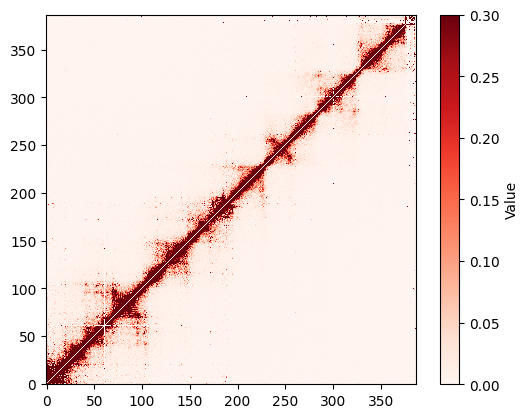

In [16]:
# original matrix(fq)
original = get_hic_data_matrix(conn, chromosome_name, cell_line, sequences)
plt.imshow(original, cmap='Reds', interpolation='nearest', origin='lower', vmin=0, vmax=0.3)
plt.colorbar(label="Value")
plt.show()

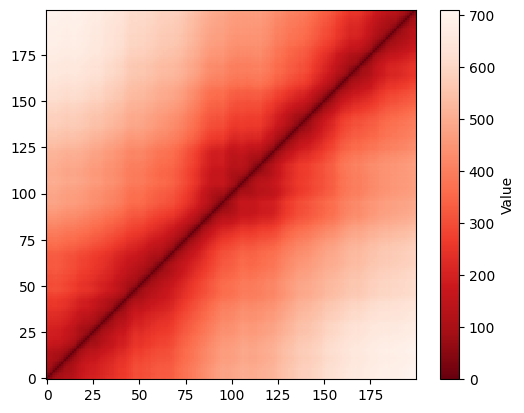

In [19]:
avg_distance_data = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
plt.imshow(avg_distance_data, cmap='Reds_r', interpolation='nearest', origin='lower')
plt.colorbar(label="Value")
plt.show()

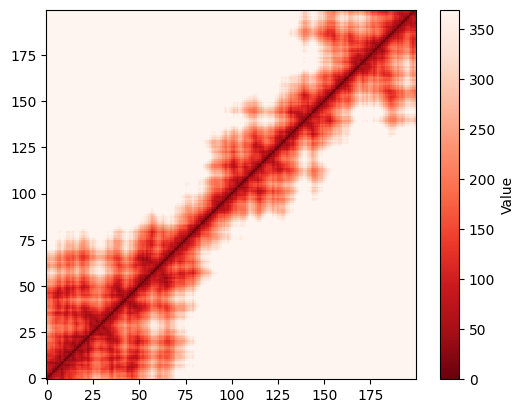

In [31]:
# distance correlation
min_val = np.min(sample_distance_vector)
max_val = np.max(sample_distance_vector)
plt.imshow(sample_distance_vector, cmap='Reds_r', interpolation='nearest', origin='lower', vmin=min_val, vmax=0.3*max_val)
plt.colorbar(label="Value")
plt.show()

In [36]:
df = pd.read_csv("./Calu3_chr8_127200000_127750000.csv")
print(min(df['sampleid']), max(df['sampleid']))

0 4999


In [44]:
df = pd.read_csv("./GM12878_chr2_106470000_106800000_local.csv")
# df = pd.read_csv("./Calu3_chr8_127200000_127750000.csv")
# df = pd.read_csv("./GM12878_chr22_18500000_18660000.csv")

df = df[df['sampleid'] == 1000].sort_values(by='pid')
# df = df[df['sampleid'] == 2547].sort_values(by='pid')
# df = df[df['sampleid'] == 1000].sort_values(by='pid')
df.head()

,pid,cell_line,chrid,sampleid,start_value,end_value,x,y,z,insert_time
66000,54186909,GM12878,chr2,1000,106470000,106800000,138.973461,33.606450,-120.987401,2025-07-24 01:22:04
66001,54186910,GM12878,chr2,1000,106470000,106800000,143.789157,12.345226,-147.458725,2025-07-24 01:22:04
66002,54186911,GM12878,chr2,1000,106470000,106800000,112.715000,10.287689,-133.101677,2025-07-24 01:22:04
66003,54186912,GM12878,chr2,1000,106470000,106800000,82.976416,26.062145,-126.563732,2025-07-24 01:22:04
66004,54186913,GM12878,chr2,1000,106470000,106800000,91.603377,58.296903,-134.466736,2025-07-24 01:22:04


In [46]:
import math

df = pd.read_csv("./GM12878_chr2_106470000_106800000_local.csv")

def compute_three_distances(df, idx1, idx2, idx3):
    p1 = df.iloc[idx1][['x', 'y', 'z']].values
    p2 = df.iloc[idx2][['x', 'y', 'z']].values
    p3 = df.iloc[idx3][['x', 'y', 'z']].values

    def euclidean_distance(a, b):
        return math.sqrt(sum((a - b) ** 2))

    d12 = euclidean_distance(p1, p2)
    d13 = euclidean_distance(p1, p3)
    d23 = euclidean_distance(p2, p3)

    print(f"Distance between row {idx1} and row {idx2}: {d12:.4f}")
    print(f"Distance between row {idx1} and row {idx3}: {d13:.4f}")
    print(f"Distance between row {idx2} and row {idx3}: {d23:.4f}")


compute_three_distances(df, 17, 37, 53)


Distance between row 17 and row 37: 215.5391
Distance between row 17 and row 53: 202.9686
Distance between row 37 and row 53: 106.0970


In [47]:
df = pd.read_csv("./Calu3_chr8_127200000_127750000.csv")
df = df[df['sampleid'] == 2547].sort_values(by='pid')

compute_three_distances(df, 1, 109, 53)

Distance between row 1 and row 109: 127.8200
Distance between row 1 and row 53: 174.3968
Distance between row 109 and row 53: 271.2850
